# Load Libraries

In [2]:
import os
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import reciprocal
import pkg_resources
import sklearn
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import tqdm # nice progress bar
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import classification_report, confusion_matrix
import earthpy.plot as ep

# Load Data

In [4]:
# Load the quality-checked spectra and metadata from numpy variables
spectra = np.load('../spectral_images/indian_pines/indian_pines_data.npy')
name1 = np.load('../spectral_images/ground_truth_images/indian_pines_gt.npy')# the genus and species if known, otherwise the common name (or material name for soil, road, etc.)
labels = ['Alfalfa','Corn-notill','Corn-mintill','Corn','Grass-pasture','Grass-trees','Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill','Soybean-clean','Wheat','Woods','Buildings-Grass-Trees-Drives','Stone-Steel-Towers']
#https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes

# Assemble X and Y for training
X = spectra.reshape(-1, spectra.shape[-1])
print(X.shape)

name = name1.reshape(-1)
print(name.shape)
Yn = name

print(X.shape,Yn.shape)
print(f'Number of names: {len(np.unique(Yn))}: {np.unique(Yn)}\n')

nSpec = X.shape[0]
nBands = X.shape[1]
print(f'Number of Spectra: {nSpec}')
print(f'Number of Bands: {nBands}')

Y_type = Yn
Y_labels = np.unique(Y_type)
nClasses = len(Y_labels)
Y = np.zeros(nSpec, dtype=int)
for i in range(nSpec):
    Y[i] = np.where(Y_labels == Y_type[i])[0]

(21025, 200)
(21025,)
(21025, 200) (21025,)
Number of names: 17: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

Number of Spectra: 21025
Number of Bands: 200


# Plots

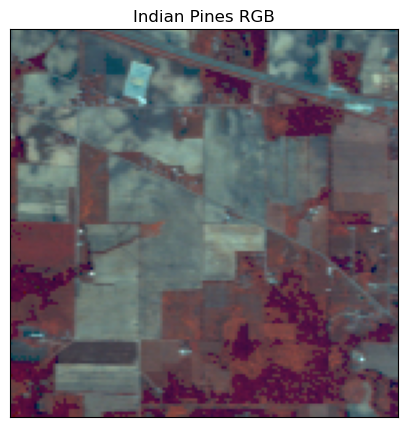

In [6]:
# RGB Image
fig, ax = plt.subplots(figsize=(5, 15))
mdata = np.moveaxis(spectra, -1, 0)
ep.plot_rgb(arr = mdata, rgb=(35, 16, 9), title="Indian Pines RGB", ax=ax) #35, 16, 9 as in paper https://www.researchgate.net/figure/Indian-Pines-dataset-a-A-false-composite-image-with-R-G-B-bands-35-16-9-b-The_fig3_344409752
plt.savefig('output/pines_rgb.png') 
plt.show()

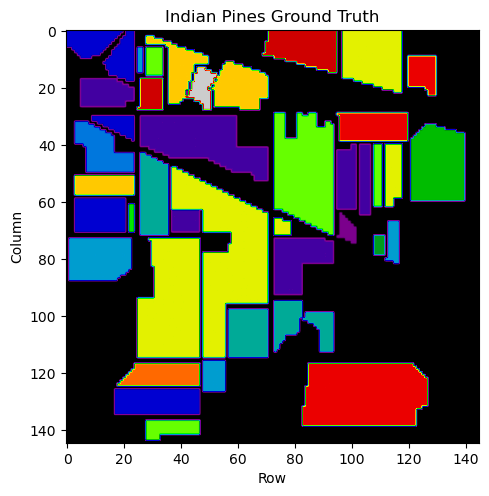

In [7]:
# Ground Truth Image
plt.figure(figsize = (5, 15))
plt.imshow(name1, cmap = 'nipy_spectral')
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Indian Pines Ground Truth')
plt.tight_layout()
plt.savefig('output/pines_groundtruth.png') 
plt.show()

# 80/20 Split

In [9]:
# Create a test-train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y) # 80% of the data in the test set
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print(X_test.shape,Y_test.shape[0] / Y.shape[0])

(16820, 200) 0.8
(4205, 200) 0.2


### Lazzy Classifier

### LDA

In [37]:
# Compute the common mean for LDA
nbands = X_train.shape[1] #X_train
nspec = X_test.shape[0] #X_test

nClasses = len(np.unique(labels))
class_means = np.zeros((nClasses, nbands))
class_covariances = np.zeros((nClasses, nbands, nbands))
C = np.zeros((nbands,nbands))

class_indices = np.unique(Y_train).astype(int) #Y_train
for idx in class_indices:
    if idx > 0: 
        class_locations = np.where(Y_train==idx)[0] #Y_train
        num_class_spectra = len(class_locations)
        class_spectra = X_train[class_locations,:] #X_train
        class_means[idx-1,:] = np.mean(class_spectra, axis=0)
        class_covariances[idx-1,:,:] = np.cov(class_spectra.T) 
        C = C + num_class_spectra*class_covariances[idx-1,:,:]

num_labeled_spectra = np.sum(Y_train>0) #Y_train
C = C/num_labeled_spectra

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)

WimList = np.matmul(W.T, X_test.T).T #X_test
 
# Compute Mahalanobis Distance to mean for each class, for all pixels
MD_all = np.zeros((nspec, nClasses))
for class_idx in range(nClasses):    
    # demean each pixel
    mu = class_means[class_idx,:]
    # whiten the mean
    Wmu = np.matmul(W.T, mu).T
    # subtract whitened mean from whitened data
    WimList_demean = WimList-Wmu
    # compute Mahalanobis Distance
    MDs = np.sum(WimList_demean**2, axis=1)
    MD = np.sqrt(MDs)
    # classify by minimum Mahalanobis distance
    MD_all[:,class_idx] = MD

LDA_class_list = np.argmin(MD_all, axis=1)
LDA_class_image = np.reshape(LDA_class_list, (nspec))

### Evaluate LDA

Accuracy: 0.7746341463414634
Balanced Accuracy: 0.8286693022406262
F1 Score: 0.7754280317543999


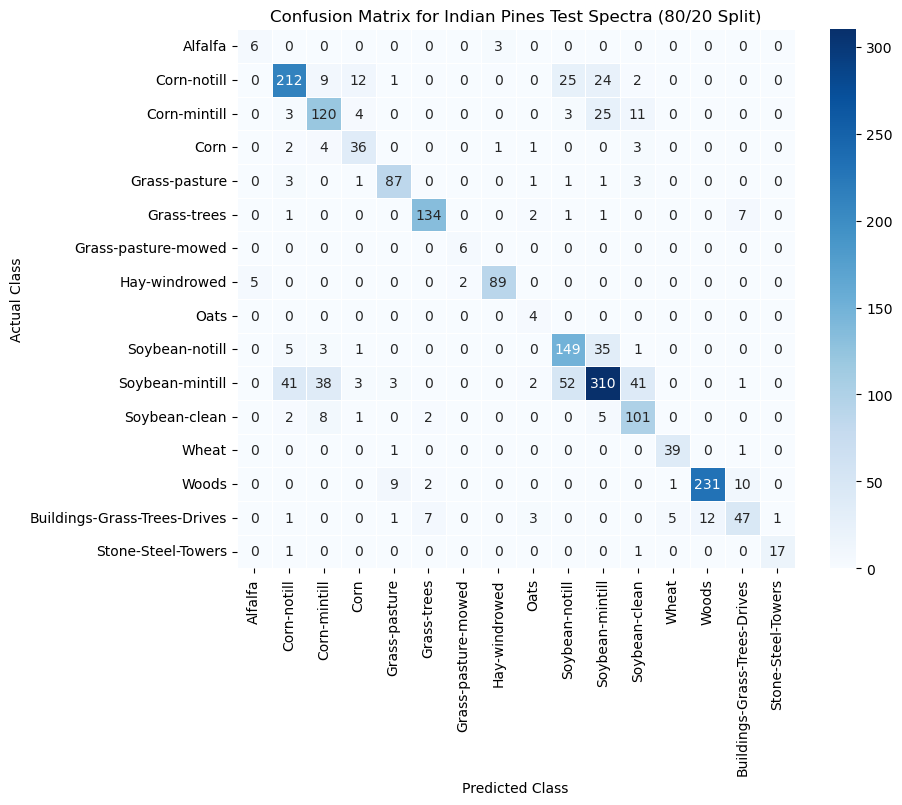

In [14]:
class_names = np.unique(labels)

y_true = Y_test[np.where(Y_test>0)[0]] #Y_test
y_pred = LDA_class_list[np.where(Y_test>0)[0]] #Y_test

# modifying for scoring
y_true = y_true - 1
y_true = (y_true).astype(int)

#Metrics
acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc}')
bal = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {bal}')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

#Confusion Matrix
def plot_confusion_matrix(actual, predicted, labels):
    fig, ax = plt.subplots(figsize=(9,7)) 
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidth=.5, ax=ax)
    ax.set_title('Confusion Matrix for Indian Pines Test Spectra (80/20 Split)')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(y_true, y_pred, labels)
plt.savefig('output/pines_80_20_confusionMatrix.png')

# 60/40 Split

In [16]:
# Create a test-train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y) # 60% of the data in the test set
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print(X_test.shape,Y_test.shape[0] / Y.shape[0])

(12615, 200) 0.6
(8410, 200) 0.4


### Lazy Classifier

### LDA

In [19]:
# Compute the common mean for LDA
nbands = X_train.shape[1] #X_train
nspec = X_test.shape[0] #X_test

nClasses = len(np.unique(labels))
class_means = np.zeros((nClasses, nbands))
class_covariances = np.zeros((nClasses, nbands, nbands))
C = np.zeros((nbands,nbands))

class_indices = np.unique(Y_train).astype(int) #Y_train
for idx in class_indices:
    if idx > 0: 
        class_locations = np.where(Y_train==idx)[0] #Y_train
        num_class_spectra = len(class_locations)
        class_spectra = X_train[class_locations,:] #X_train
        class_means[idx-1,:] = np.mean(class_spectra, axis=0)
        class_covariances[idx-1,:,:] = np.cov(class_spectra.T) 
        C = C + num_class_spectra*class_covariances[idx-1,:,:]

num_labeled_spectra = np.sum(Y_train>0) #Y_train
C = C/num_labeled_spectra

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)

WimList = np.matmul(W.T, X_test.T).T #X_test
 
# Compute Mahalanobis Distance to mean for each class, for all pixels
MD_all = np.zeros((nspec, nClasses))
for class_idx in range(nClasses):    
    # demean each pixel
    mu = class_means[class_idx,:]
    # whiten the mean
    Wmu = np.matmul(W.T, mu).T
    # subtract whitened mean from whitened data
    WimList_demean = WimList-Wmu
    # compute Mahalanobis Distance
    MDs = np.sum(WimList_demean**2, axis=1)
    MD = np.sqrt(MDs)
    # classify by minimum Mahalanobis distance
    MD_all[:,class_idx] = MD

LDA_class_list = np.argmin(MD_all, axis=1)
LDA_class_image = np.reshape(LDA_class_list, (nspec))

### Evaluate LDA

Accuracy: 0.7784825567211515
Balanced Accuracy: 0.832070047151838
F1 Score: 0.7793977413850959


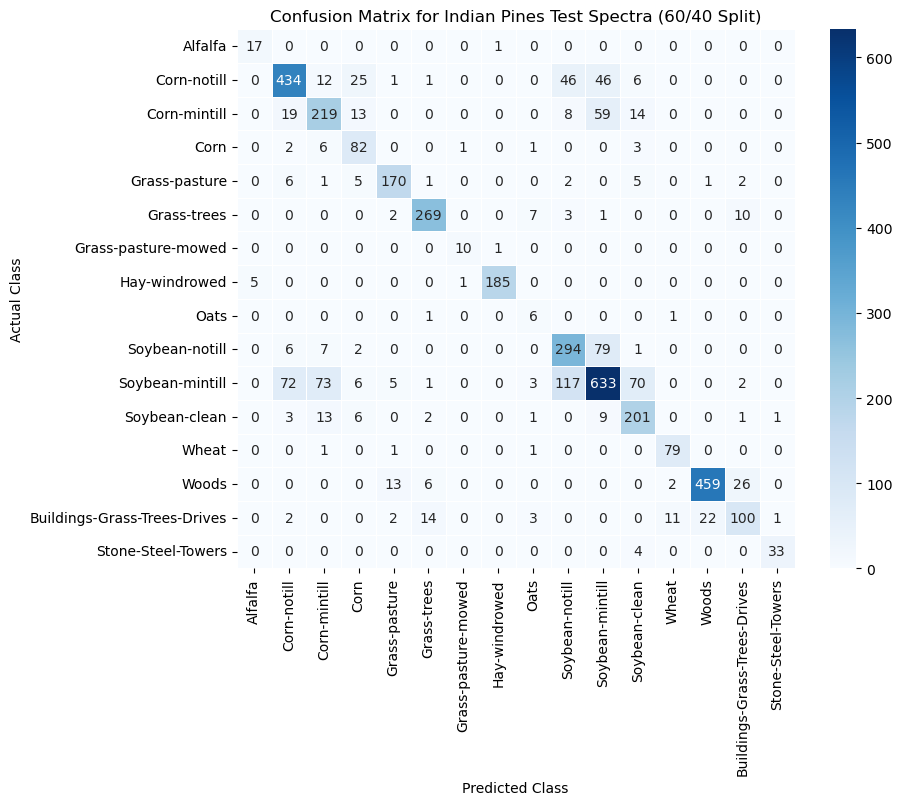

In [21]:
class_names = np.unique(labels)

y_true = Y_test[np.where(Y_test>0)[0]] #Y_test
y_pred = LDA_class_list[np.where(Y_test>0)[0]] #Y_test

# modifying for scoring
y_true = y_true - 1
y_true = (y_true).astype(int)

#Metrics
acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc}')
bal = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {bal}')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

#Confusion Matrix
def plot_confusion_matrix(actual, predicted, labels):
    fig, ax = plt.subplots(figsize=(9,7)) 
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidth=.5, ax=ax)
    ax.set_title('Confusion Matrix for Indian Pines Test Spectra (60/40 Split)')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(y_true, y_pred, labels)
plt.savefig('output/pines_60_40_confusionMatrix.png')